# Comparative Analysis
In this notebook, we compare ClaSS with different competitors regarding scalability.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd
import daproli as dp

import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import gc
import Orange
import sys
sys.path.append("../")

from tqdm import tqdm
from scipy import stats

In [4]:
from src.profile_visualization import plot_profile, plot_profile_with_ts
from src.utils import load_combined_dataset, load_benchmark_dataset
from src.clazz.window_size import suss

Let's choose a score for evaluation (F1 or Covering).

In [5]:
eval_score = "covering_score"

In [17]:
df_comb = load_combined_dataset()
df_comb['ts_len'] = df_comb.time_series.apply(len)
# takes too much space
df_comb.drop("time_series", axis=1, inplace=True)
df_comb.head()

,name,window_size,change_points,ts_len
0,Adiac,10,"[572, 1012, 1232]",1408
1,ArrowHead,10,[753],1506
2,Beef,50,[705],1410
3,BeetleFly,10,[1280],2560
4,BirdChicken,20,[1280],2560


Let's load the scores from the different methods.

In [10]:
datasets = ["UTSA", "TSSB", "PAMAP", "mHealth"] # "MIT-BIH-VE", "MIT-BIH-Arr", "SleepDB", "WESAD"
converters = dict([(column, lambda s: np.sum(eval(s))) for column in ["runtimes"]])
dfs = list()
    
name, file_name = "ClaSS", "FlinkClaSS.csv"

df = []

for d in tqdm(datasets):
    tmp = pd.read_csv(f"../experiments/flink_{d}/{file_name}.gz", usecols=["dataset", "runtime", "memory"], converters=converters, compression="gzip")
    tmp["name"] = d
    tmp.memory = tmp.memory / 1024 ** 2

    df.append(tmp)
    gc.collect()

df = pd.concat(df)    
df.sort_values(by="dataset", inplace=True)
df.reset_index(drop=True, inplace=True)

df

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.29it/s]


,dataset,runtime,memory,name
0,Adiac,10.162363,6.175781,TSSB
1,ArrowHead,11.285746,-12.500000,TSSB
2,Beef,14.745115,79.542969,TSSB
3,BeetleFly,24.536208,85.292969,TSSB
4,BirdChicken,23.424342,84.695312,TSSB
5,CBF,10.710303,77.941406,TSSB
6,Cane,49.124062,87.367188,UTSA
7,Car,21.037045,83.984375,TSSB
8,Chinatown,2.340616,0.203125,TSSB
9,ChlorineConcentration,71.147328,86.660156,TSSB


Let's calculate the sum/mean/std score.

In [11]:
np.round((df.runtime.sum(axis=0) / 60) / 60, 0)

65.0

In [14]:
np.round(df.memory.mean(axis=0), 0)

25.0

In [15]:
np.round(df.memory.std(axis=0), 0)

39.0

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression().fit(df_comb[df_comb.name.isin(df.dataset)].ts_len.to_numpy().reshape(-1,1), df.runtime.to_numpy().reshape(-1,1))
y_min, y_max = lr.predict(np.array([df_comb[df_comb.name.isin(df.dataset)].ts_len.min(), df_comb[df_comb.name.isin(df.dataset)].ts_len.max()]).reshape(-1,1)).flatten()

# mean deviation predicted / actual ts length
np.mean(np.abs(1 - lr.predict(df_comb[df_comb.name.isin(df.dataset)].ts_len.to_numpy().reshape(-1,1)).flatten() / df.runtime.to_numpy()))


# print(f"Mean absolute error: {np.round(mean_absolute_error(df_runtimes.ClaSS.to_numpy(), lr.predict(df_comb.ts_len.to_numpy().reshape(-1,1)).flatten()), 3)} seconds")

0.2972087171047753

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2013/3282976670.py:14: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2013/3282976670.py:17: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


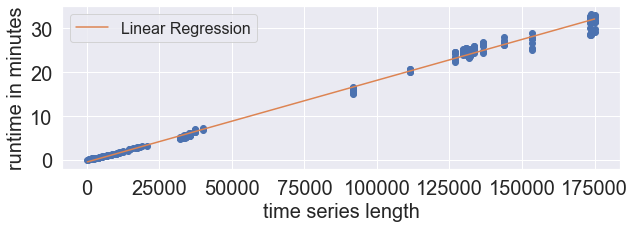

In [23]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(10,3))
ax.scatter(df_comb[df_comb.name.isin(df.dataset)].ts_len, df.runtime / 60)

ax.plot([df_comb[df_comb.name.isin(df.dataset)].ts_len.min(), df_comb[df_comb.name.isin(df.dataset)].ts_len.max()], [y_min / 60, y_max / 60], c="C1", label="Linear Regression")

# ax.set_yscale('log')

ax.set_xlabel("time series length", fontsize=fontsize)
ax.set_ylabel("runtime in minutes", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.legend(loc=2, prop={'size': fontsize-4})

plt.savefig(f"../figures/runtime_length.pdf", bbox_inches="tight")

/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2013/758962310.py:14: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/5_/fv_bzq1n4n76j6l_jqgndj6c0000gn/T/ipykernel_2013/758962310.py:17: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


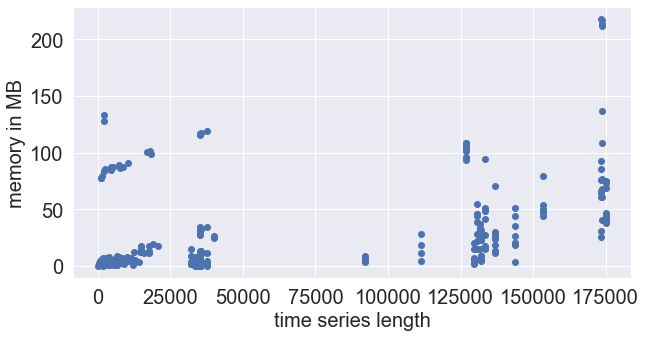

In [33]:
fontsize = 20

# some failed and memory in negative
pos = df[df.memory >= 0].dataset

_, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(df_comb[df_comb.name.isin(pos)].ts_len, df.memory[df.dataset.isin(pos)])
ax.set_xlabel("time series length", fontsize=fontsize)
ax.set_ylabel("memory in MB", fontsize=fontsize)

# ax.set_yscale('log')

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_memory.pdf", bbox_inches="tight")